In [1]:
"""Create parameters.py and load it"""

# Directory for .inp file:
path = 'INP file examples\\chem_Otomo2018_without_O.inp'

# import libraries:
import importlib   # For reloading your own files
from termcolor import colored   # for colored error messages
# my own files:
try:
    import inp_data_extractor as inp
except:
    try:
        import Bubble_dynamics_simulation.inp_data_extractor as inp
    except:
        print(colored(f'Error, \'inp_data_extractor.py\' not found', 'red'))
importlib.reload(inp)   # reload changes you made
inp.extract(path)

import parameters as par   # numeric constants and coefficents
importlib.reload(par)   # reload changes you made
print(par.model)

path=INP file examples\chem_Otomo2018_without_O.inp
Note, lambda value for specie 'H' is not in data.py: 0.0 is used
Note, lambda value for specie 'NH2' is not in data.py: 0.0 is used
Note, lambda value for specie 'NH' is not in data.py: 0.0 is used
Note, lambda value for specie 'N' is not in data.py: 0.0 is used
Note, lambda value for specie 'NNH' is not in data.py: 0.0 is used
Note, lambda value for specie 'N2H4' is not in data.py: 0.0 is used
Note, lambda value for specie 'N2H3' is not in data.py: 0.0 is used
Note, lambda value for specie 'N2H2' is not in data.py: 0.0 is used
Note, lambda value for specie 'H2NN' is not in data.py: 0.0 is used
Warning, third body 'H2O' is not in species in line 64 (' H2/2.5/ H2O/12/ AR/0.0/ ') in reaction 'H2+M=H+H+M'
Warning, third body 'AR' is not in species in line 64 (' H2/2.5/ H2O/12/ AR/0.0/ ') in reaction 'H2+M=H+H+M'
model: chem_Otomo2018_without_O
File 'parameters.py' succesfully created
chem_Otomo2018_without_O


In [2]:
"""Libraries"""

# for plotting:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})

import numpy as np   # matrices, math
import time   # runtime measurement
import random   # random number generator
from multiprocessing import Pool, cpu_count   # multithreading
import importlib   # reload changes you made
import json   # convert dictionary to string

# my own file:
already_imported = 'gd' in globals()
try:
    import gradient_descent as gd
except:
    try:
        import Bubble_dynamics_simulation.gradient_descent as gd
    except:
        print(colored(f'Error, \'gradient_descent.py\' not found', 'red'))
if already_imported: importlib.reload(gd)   # reload changes you made

model: chem_Otomo2018_without_O
target specie: NH3
excitation: no_excitation (control parameters: [])
enable heat transfer: True	enable evaporation: False	enable reactions: True	enable dissipated energy: False


In [3]:
"""Control parameter ranges and division"""
# a list for each control parameter, containing all the possible values

ranges = dict(
  # Initial conditions:
    # bubble equilibrium radius [m]
    R_E = [1.0e-6*x for x in [1.0, 10.0]], # [um --> m]
    # initial radius / equilibrium radius R_0/R_E [-]
    ratio = [1.0, 10.0],
    # indexes of species in initial bubble
    gases=[[par.index['N2'], par.index['H2']]],
    # Molar fractions of species in the initial bubble (H2 and N2) [-]
    fractions=[[0.25, 0.75]],
  # Ambient parameters:
    # ambient pressure [Pa]
    P_amb = [x * par.atm2Pa for x in [10.0]], # [atm --> Pa]
    # ambient temperature [K]       
    T_inf = [par.absolute_zero + x for x in [30.0]], # [°C --> K]
  # Liquid parameters:
    # water accommodation coefficient [-]
    alfa_M = [0.05],
    #P_v = par.P_v,                    # vapour pressure [Pa]
    #mu_L = par.mu_L,                  # dynamic viscosity [Pa*s]
    # sound speed [m/s]
    c_L = [par.c_L],
    # surfactant (surface tension modfier) [-]
    surfactant = [1.0],
  # Excitation parameters: (excitation_type = no_excitation)
    # -
)

for key in gd.de.excitation_args:
    if key not in ranges:
        print(colored(f'Error, {key} not in ranges', 'red'))

In [5]:
to_optimize = 'energy_efficiency'   # key in data from de.get_data()
searches = 50    # number os total searches

kwargs_list = [dict(
    ranges=ranges,
    to_optimize=to_optimize,
    start_point=gd.rand_point(ranges, padding=0.1),
    step_limit=100,
    first_step=0.2, #between two parameter combinations
    min_step=1e-4, #between two parameter combinations
    decay=0.5,
    delta=1e-5,
    log10=False,
    verbose=False,
    t_int=[0.0, 1.0],
    LSODA_timeout=30,
    Radau_timeout=300,
    ) for i in range(searches)]

In [6]:
"""Save settings as txt"""

# create folder for parameter study results:
file = gd.de.Make_dir('D:/parameter_studies/gradient_descent_test_1')

# save all settings (full_bubble_model.py, parameters.py, ranges) as txt:
to_print = gd.de.copy(kwargs_list[0])
del to_print['ranges']
del to_print['start_point']
ranges_str = f'''
ranges = {json.dumps(ranges, indent=4)}

settings = {json.dumps(to_print, indent=4)}

start_points = [
'''

for kwargs in kwargs_list:
    ranges_str += json.dumps(kwargs['start_point'], indent=4) + ',\n'
ranges_str += ']'

file.write_string(ranges_str, 'gradient_descent_settings')

Folder already exists with 0 csv in it


In [7]:
""" Gradient method, multithread"""

best_output = 1.0e30
total_point_num = 0
num = 0
to_plot = []
last_points = []
start = time.time()

with Pool(processes=cpu_count(), maxtasksperchild=10) as pool:
    results = pool.imap_unordered(gd.search, kwargs_list)
    for result in results:
        all_datas, best_outputs, elapsed = result
        point_num = sum([len(datas) for datas in all_datas])
        total_point_num += point_num
        num += 1
        to_plot.append(best_outputs)
        if len(all_datas) > 0 and len(all_datas[-1]) > 0:
            last_points.append(gd.de.copy(all_datas[-1][0]))
        if best_outputs[-1] < best_output and best_outputs[-1] > 0:
            best_output = best_outputs[-1]

        # save points
        file.new_file()
        for datas in all_datas:
            for data in datas:
                file.write_line(data)
        file.close()
        del(all_datas)
        
        # print stuff:
        if point_num==0: point_num=1
        print(f'{num: >3}/{searches}: Total {len(best_outputs): <3} steps and {point_num: <4} points, finished in {elapsed: 8.2f} [s]   ({(elapsed / point_num): 4.2f} [s/run]).   '+
              f'Final {to_optimize}: {best_outputs[-1]: 8.1f} (best: {best_output: 6.1f})')
            
file.close()
end = time.time()
elapsed = end - start
print(f'\n\nDONE')
print(f'total time: {((elapsed-elapsed % 3600) / 3600): .0f} hours {((elapsed % 3600) / 60): .0f} mins')
print(f'            {elapsed: .2f} [s]   ({(elapsed / total_point_num): .2f} [s/run])')

1  /50: Total 1   steps and 1    points, finished in   7.48 [s]   ( 7.48 [s/run]).   Final energy_efficiency:  1000000000000000019884624838656.0 (best:  1000000000000000019884624838656.0)
2  /50: Total 15  steps and 62   points, finished in  70.25 [s]   ( 1.13 [s/run]).   Final energy_efficiency:  9472354169839744450560.0 (best:  9472354169839744450560.0)
3  /50: Total 38  steps and 152  points, finished in  334.46 [s]   ( 2.20 [s/run]).   Final energy_efficiency:  262301.6 (best:  262301.6)
4  /50: Total 17  steps and 70   points, finished in  429.47 [s]   ( 6.14 [s/run]).   Final energy_efficiency:  17177.9 (best:  17177.9)
5  /50: Total 21  steps and 91   points, finished in  593.67 [s]   ( 6.52 [s/run]).   Final energy_efficiency:  17937.6 (best:  17177.9)
6  /50: Total 26  steps and 107  points, finished in  684.87 [s]   ( 6.40 [s/run]).   Final energy_efficiency:  17563.7 (best:  17177.9)
7  /50: Total 26  steps and 105  points, finished in  735.68 [s]   ( 7.01 [s/run]).   Final 

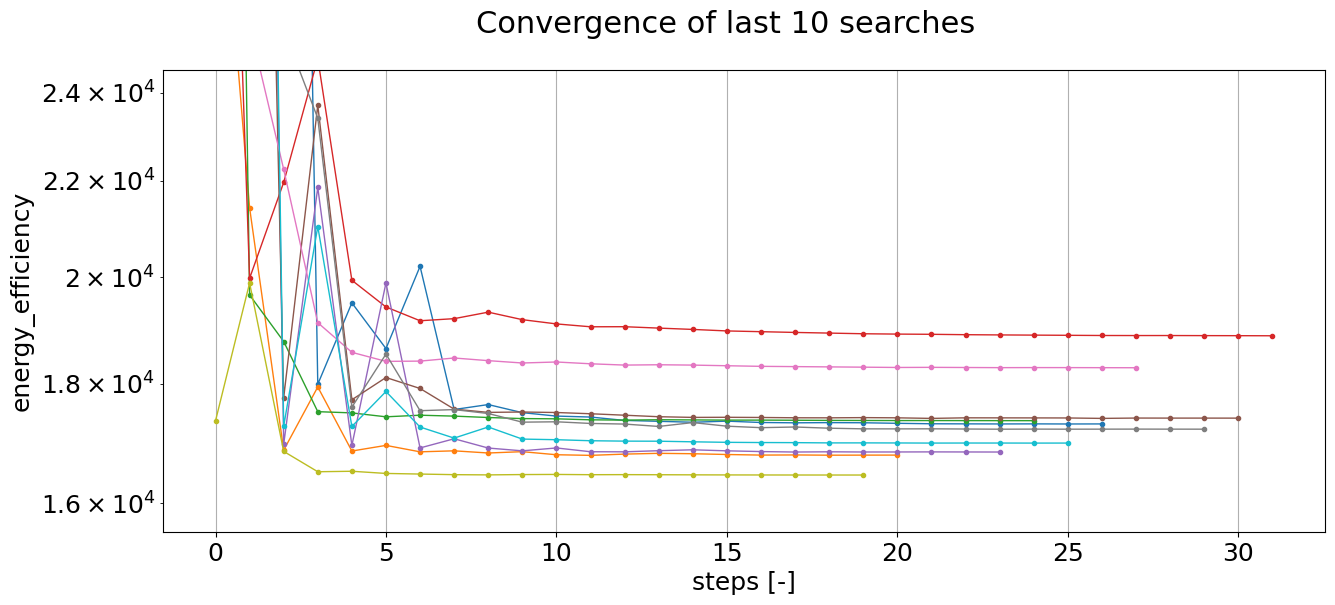

In [8]:
"""Plot convergence of last searches"""

if len(to_plot) > 10:
    to_plot2 = to_plot[-10:]
else:
    to_plot2 = to_plot

fig, ax = plt.subplots(1, 1, figsize=(15, 6))
fig.suptitle('Convergence of last 10 searches', fontsize=22)
ax.set_ylabel(f'{to_optimize}')
ax.set_ylim(0.95*best_output, 1.5*best_output)
ax.set_yscale('log')
ax.set_xlabel('steps [-]')
ax.grid()
for plot in to_plot2:
    ax.plot(plot, '.-', linewidth=1.0)
plt.show()

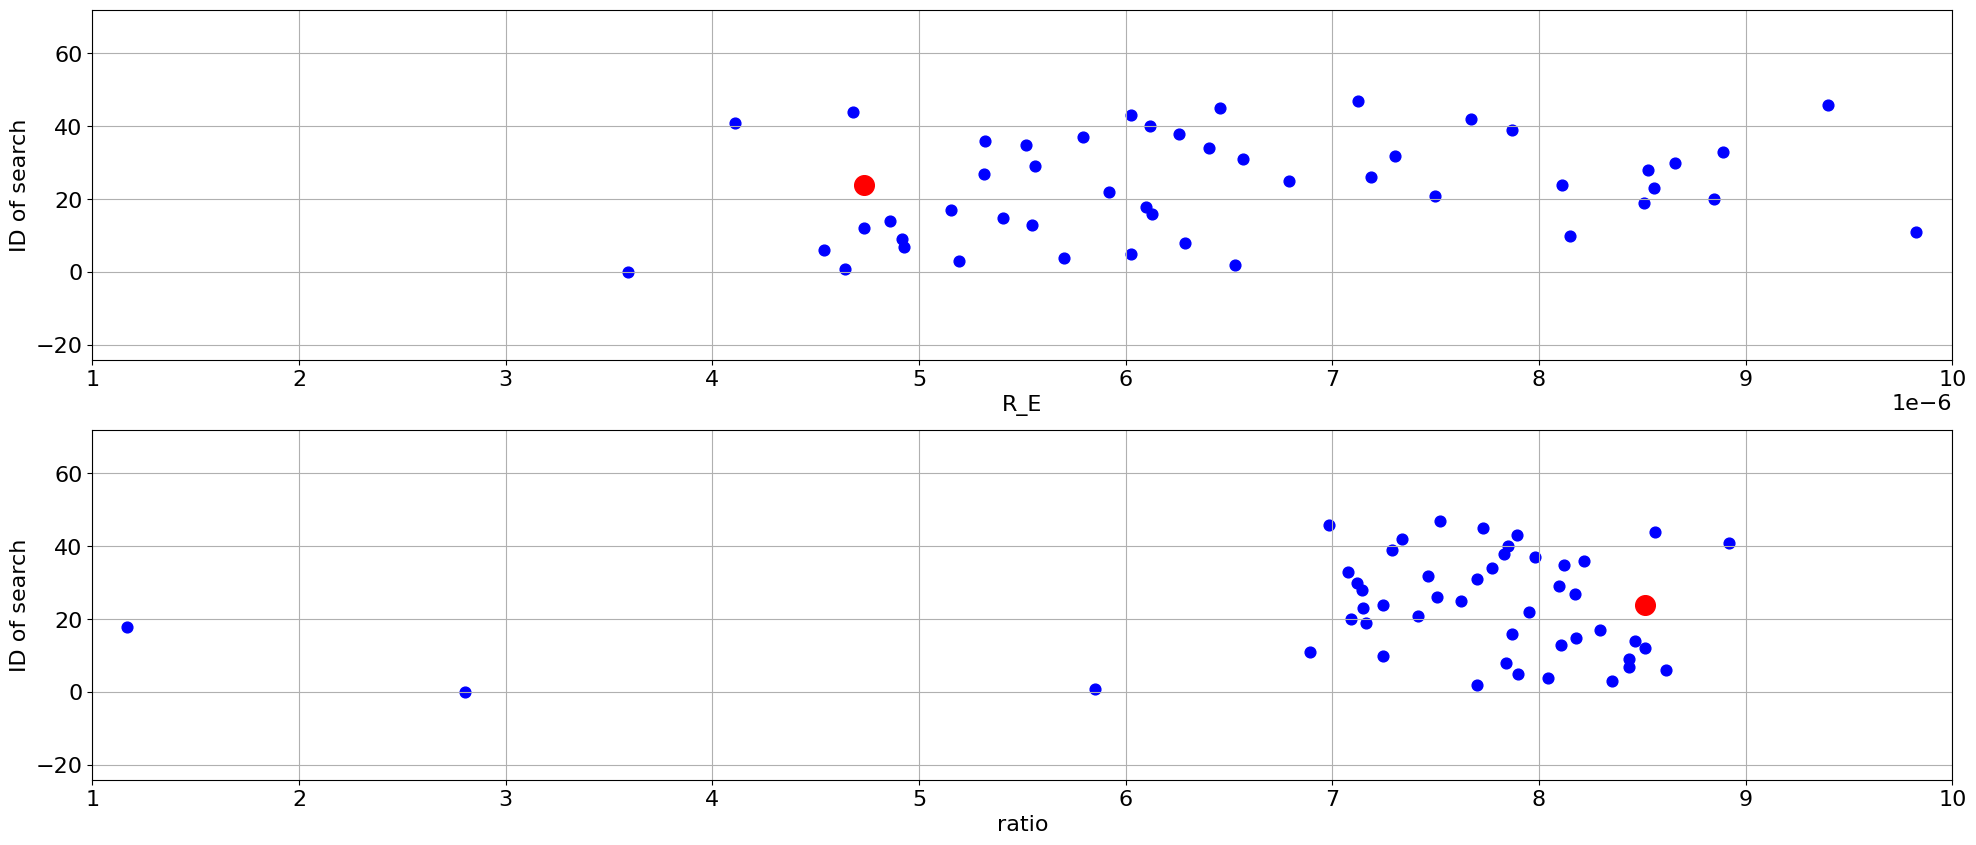

In [12]:
"""Plot the distribution of the optimums"""

plt.rcParams.update({'font.size': 16})
ranges2 = dict()
for key in ranges:
    if len(ranges[key]) > 1:
        ranges2[key] = ranges[key]

n = len(ranges2)
fig, ax = plt.subplots(n, 1, figsize=(24, 5*n))
for i, key in enumerate(ranges2):
    last_values = [last_point[key] for last_point in last_points]
    y = [i for i, last_point in enumerate(last_points)]
        
  # ploting:
    ax[i].scatter(last_values, y, s=60, color='b')
    ax[i].set_ylabel('ID of search')
    ax[i].set_xlabel(key)
    ax[i].set_xlim(ranges2[key])
    n = len(last_points)
    ax[i].set_ylim([-0.5*n, 1.5*n])
    ax[i].grid()
    # best point:
    index = [x[-1] for x in to_plot].index(best_output)
    best_point = last_points[index]
    ax[i].scatter([best_point[key]], [0.5*n], s=200, color='r')
